# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn
# merge the files
df = pd.merge(df_offers, df_transactions)
# create the pivot table
matrix = df.pivot_table(index= 'customer_name', columns='offer_id', values= 'n')
matrix.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
Allen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Bailey,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Baker,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [5]:
# change Nan values to 0 
matrix = matrix.fillna(0).reset_index()
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [6]:
# your turn


Smaller values of SS represent better clusterings up to a certain point.  SS will get smaller as the number of clusters gets larger and the sizes of the individual clusters gets smaller.  We are trying to find general categories and if there are too many clusters, we defeat that purpose.

In [7]:
# create the matrix called x_cols which has only the columns with transaction data (no customer names)
x_cols = matrix.iloc[:,1:]
x_cols.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# define the range of K's to test
K_range = range(2,11)

# initialize a dictionary to store the sum of squares (ss) values for each K
SSE = {}
# for each K, fit the model, calculate the distances from the data to the centroids and get ss
for K in K_range:
    K_means = KMeans(n_clusters= K, random_state = 5).fit(x_cols)  
    centroids = K_means.cluster_centers_ 
    K_euclid = cdist(x_cols,centroids, 'euclidean') 
    dist = np.min(K_euclid, axis=1) 
    squares = np.square(dist)
    ss = sum(squares)
    SSE[K] = ss

In [9]:
# put the SSE values into a dataframe for easy plotting
ssedf = pd.DataFrame.from_dict(SSE, orient='index')


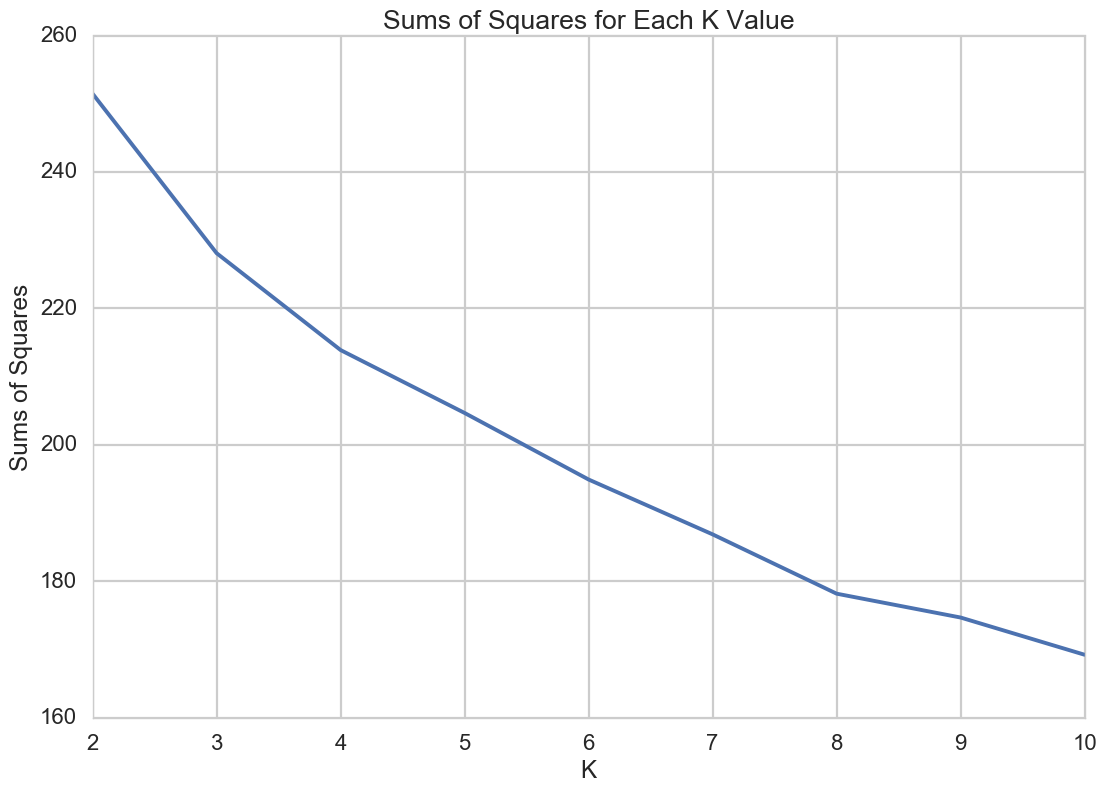

In [10]:
# plot Sums of Squares versus K values
plt.plot(ssedf)
plt.title('Sums of Squares for Each K Value')
plt.xlabel('K')
plt.ylabel('Sums of Squares')

There are several places where an "elbow" could be defined.  The first one is at K=3 but there also appears to be one at K=4 and K=8.  Let's choose K=4.

In [11]:
# fit the model for K = 4
K_means = KMeans(n_clusters= 4).fit_predict(x_cols) 
# store the cluster assignments in the matrix
matrix['cluster'] = K_means
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [12]:
# count number of data points in each cluster
num_per_cluster = matrix.cluster.value_counts()

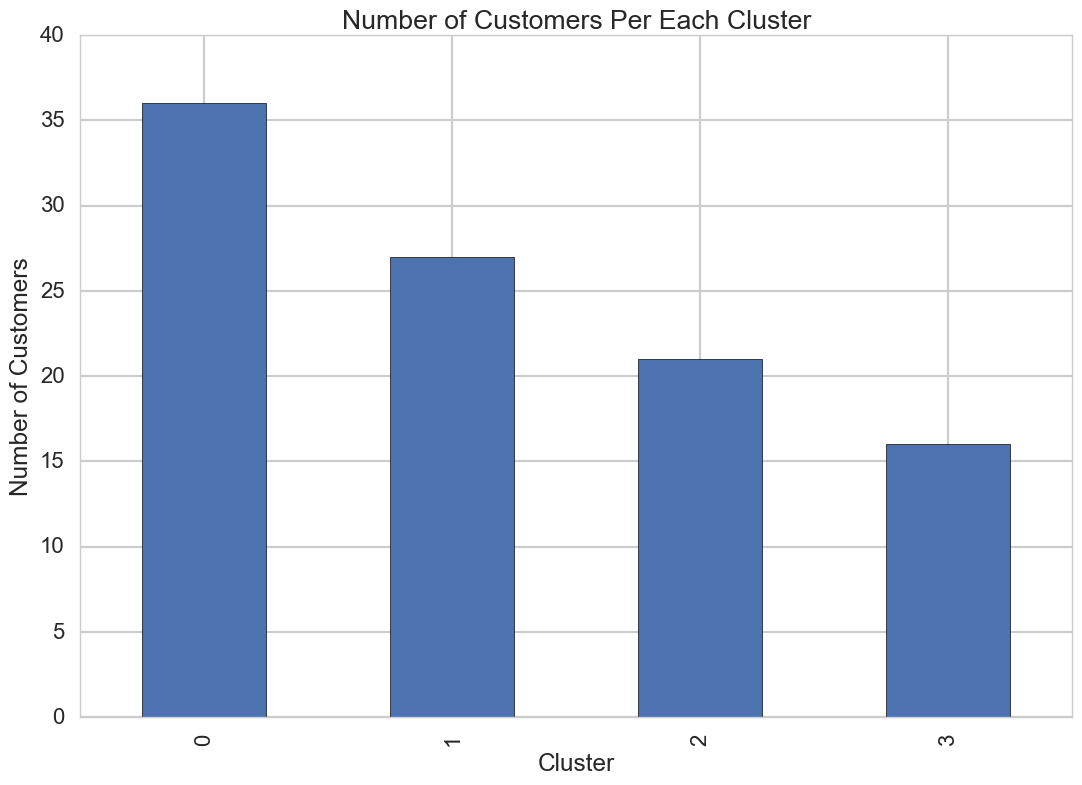

In [13]:
# create a bar chart representing the number of data points (customers) per cluster
num_per_cluster.plot(kind='bar')
plt.title('Number of Customers Per Each Cluster')
plt.xlabel('Cluster')
plt.ylabel("Number of Customers")

When using the elbow method for choosing K, it is not always obvious where the "elbow" is.  If the plot is relatively smooth, it will be difficult to choose the best K.  In this case, I observed several places that could have been chosen.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [14]:
# Your turn.


In [15]:
# import some packages we need

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

For K = 2, the average silhouette_score is 0.0917487150875


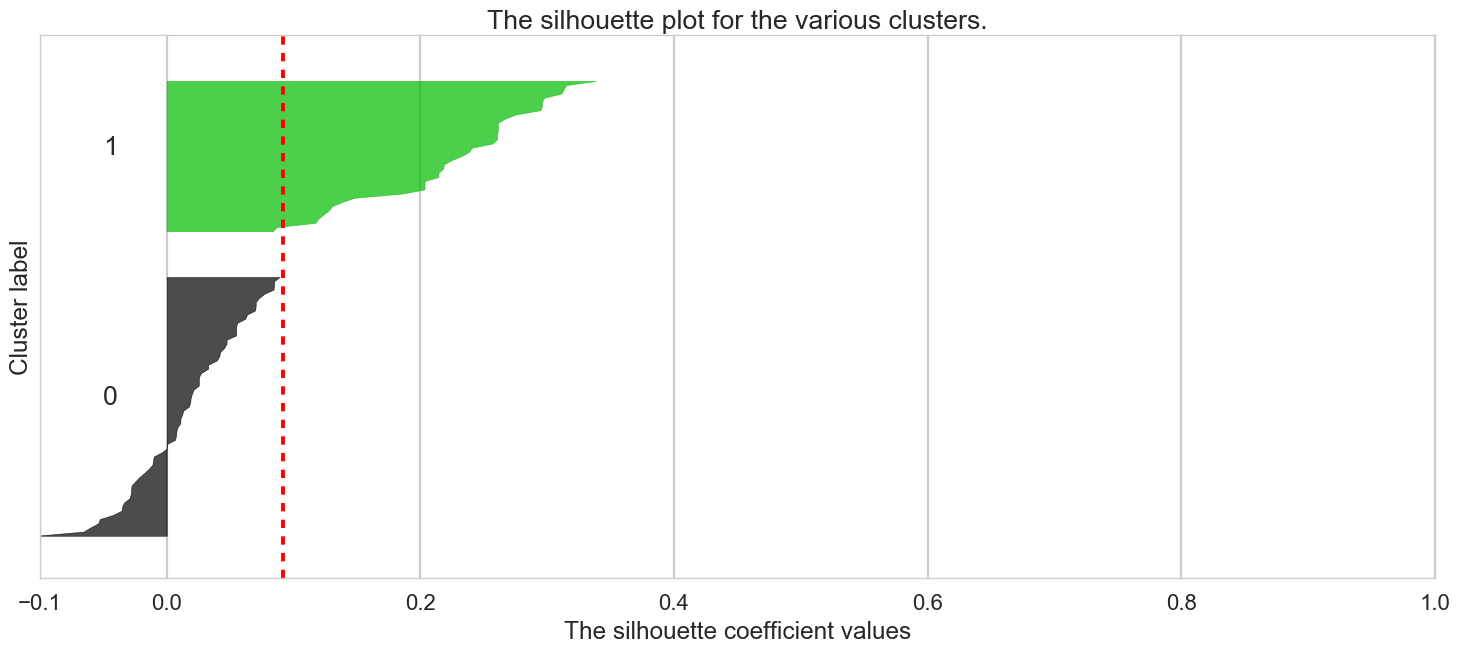

For K = 3, the average silhouette_score is 0.117699800587


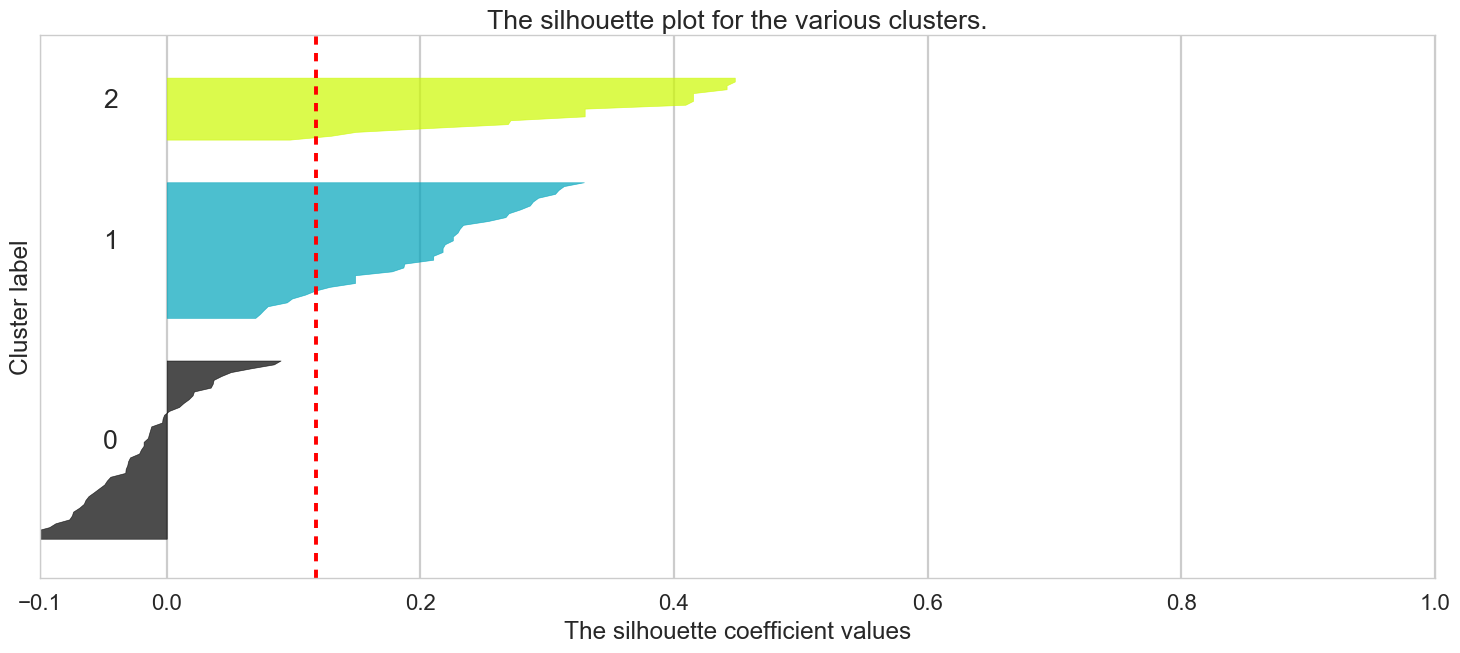

For K = 4, the average silhouette_score is 0.114705204926


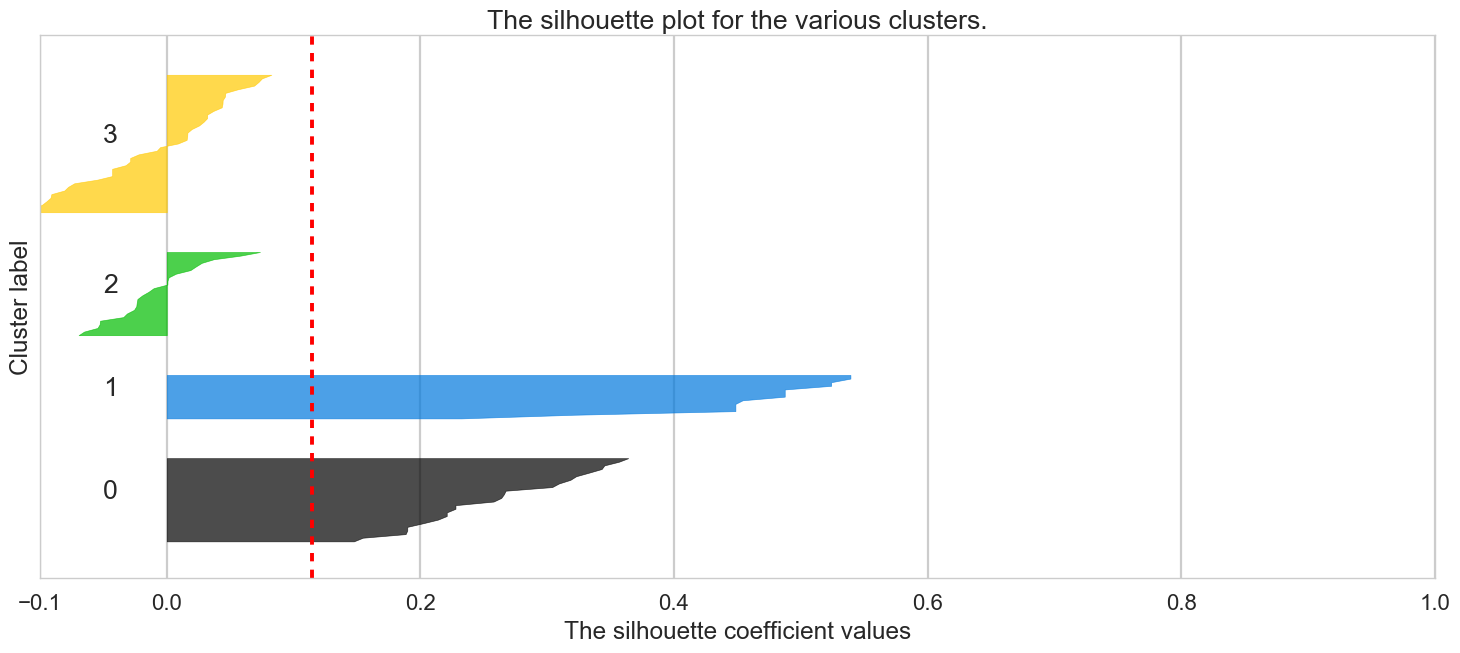

For K = 5, the average silhouette_score is 0.120909630333


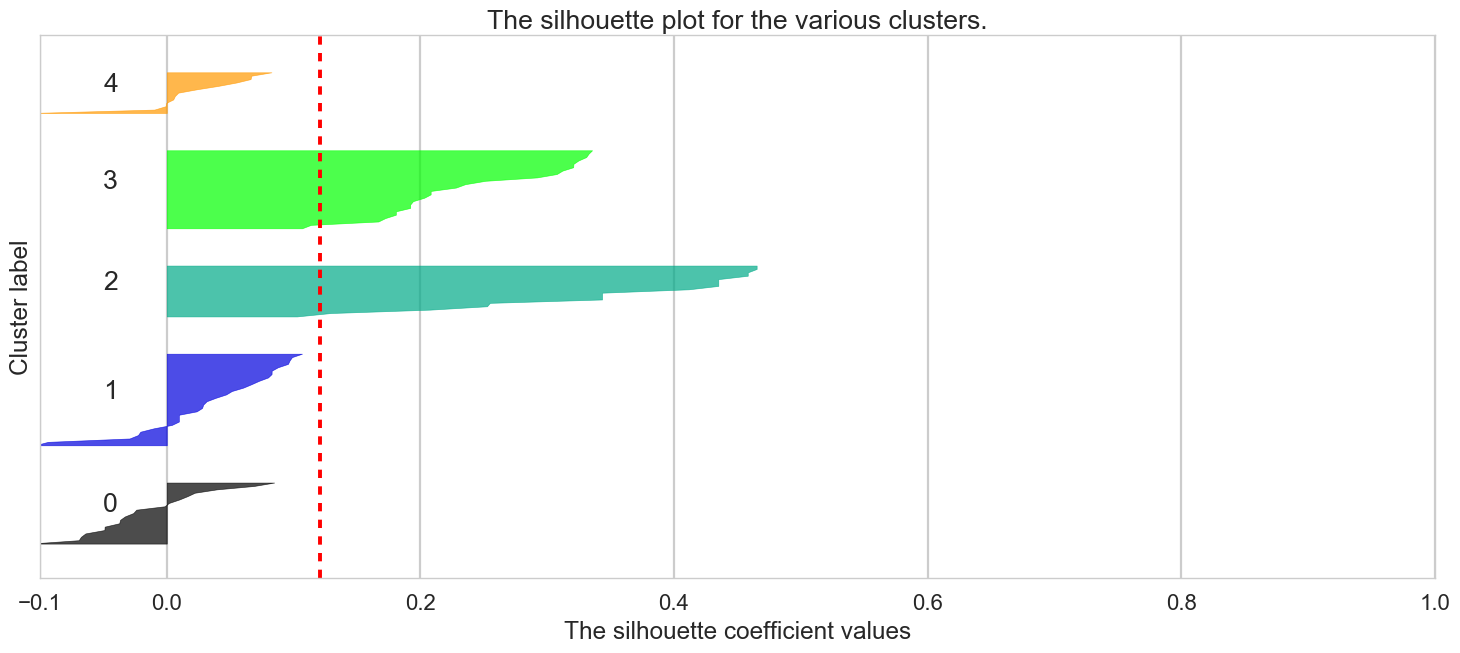

For K = 6, the average silhouette_score is 0.121461742718


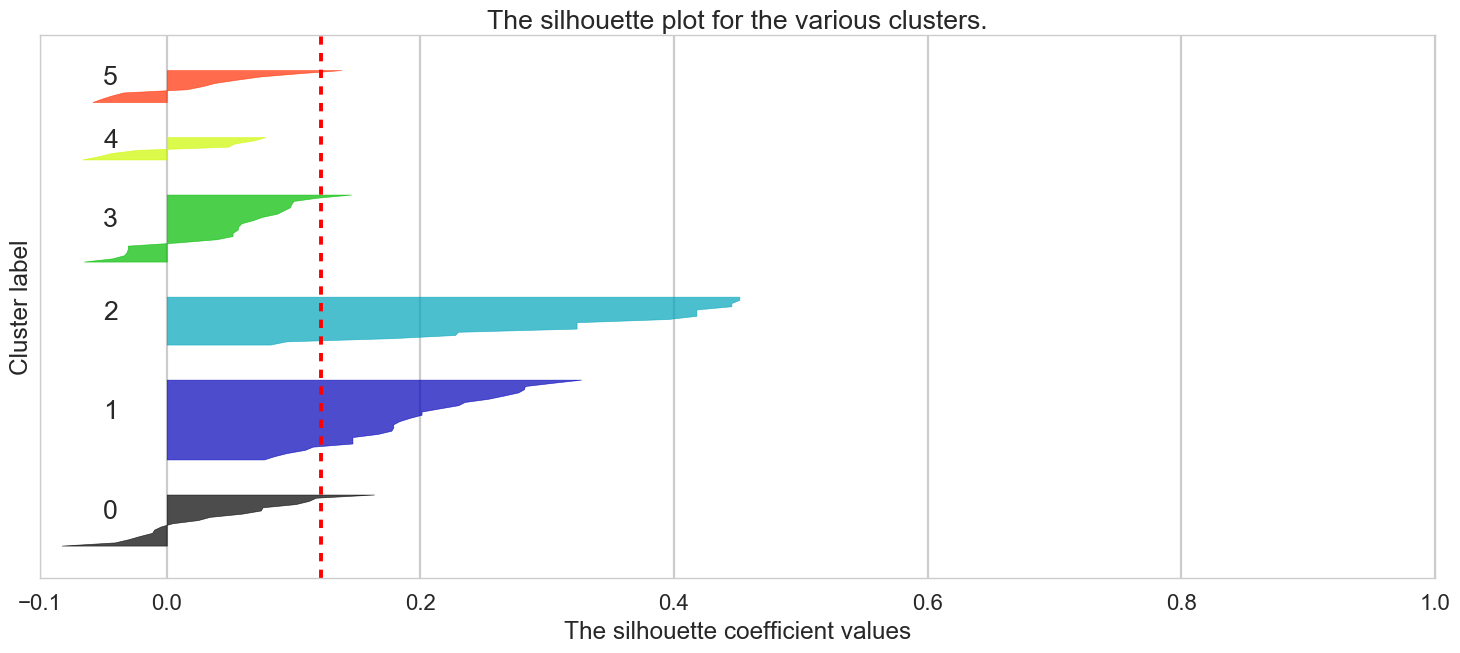

For K = 7, the average silhouette_score is 0.120156245788


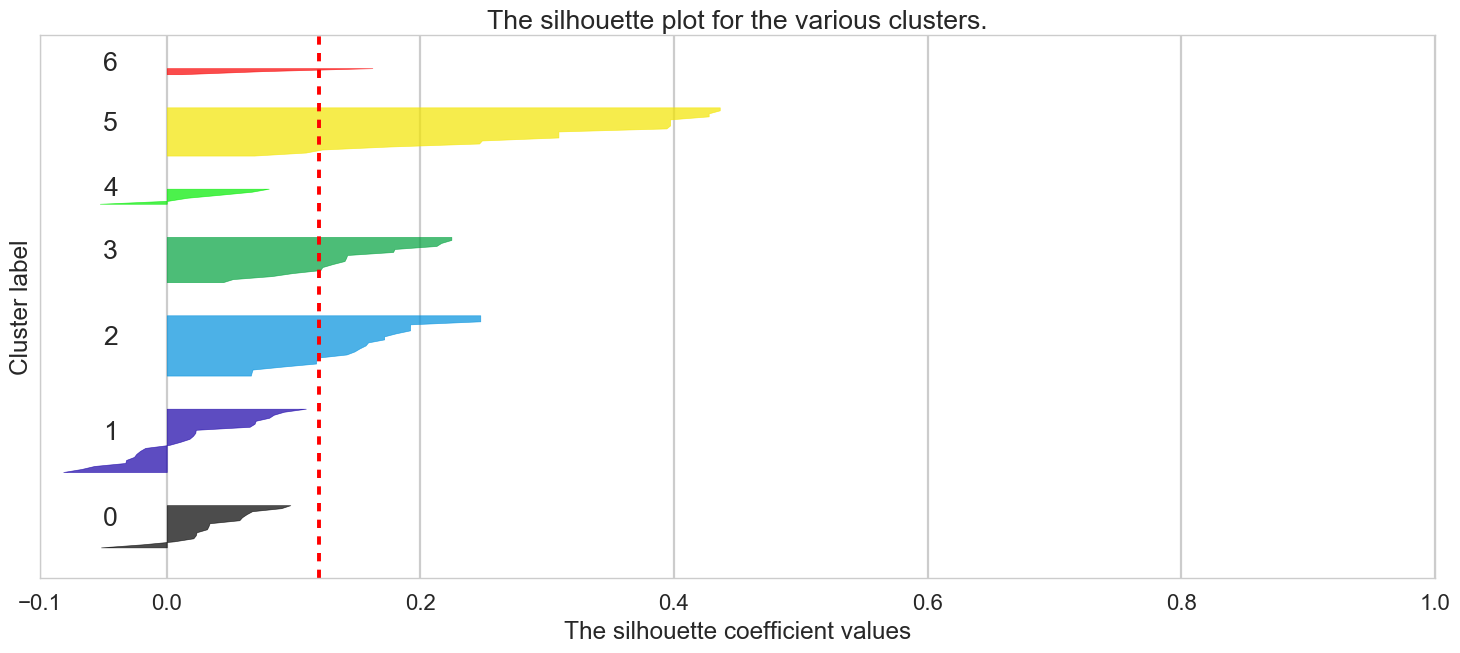

For K = 8, the average silhouette_score is 0.123987821069


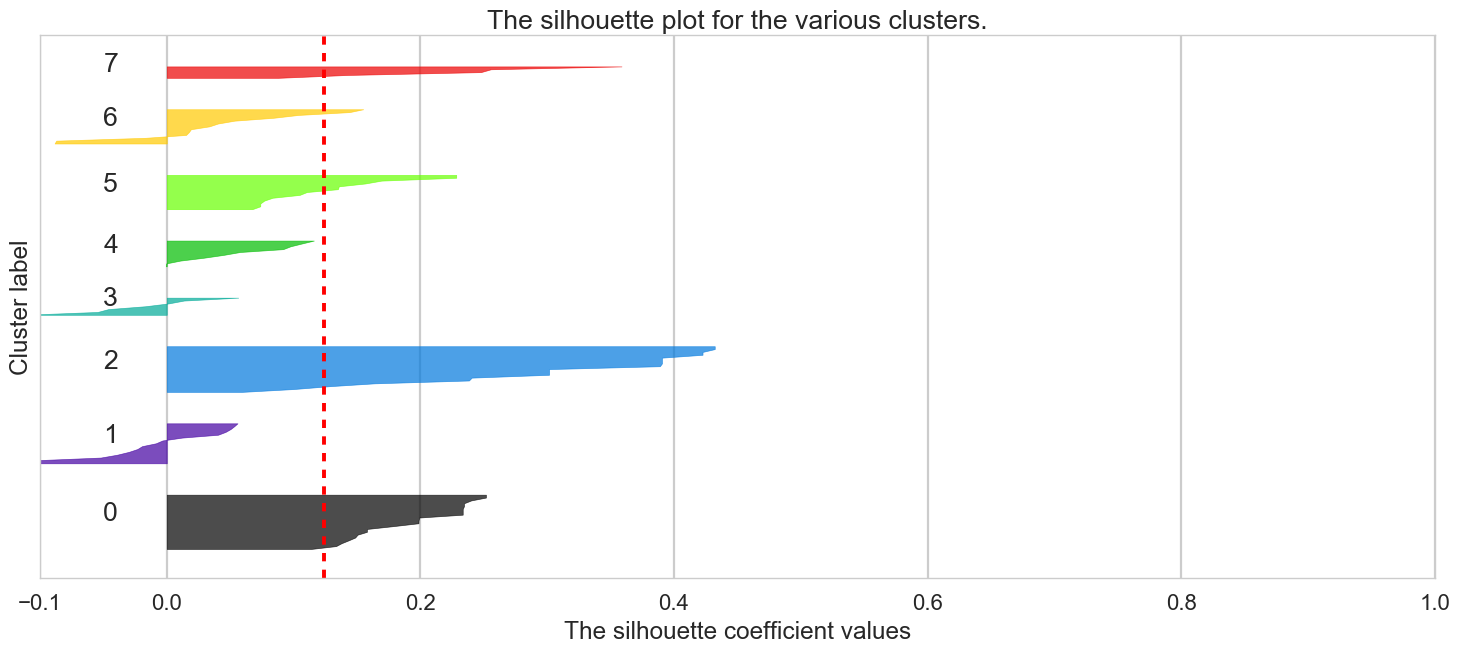

For K = 9, the average silhouette_score is 0.12129837343


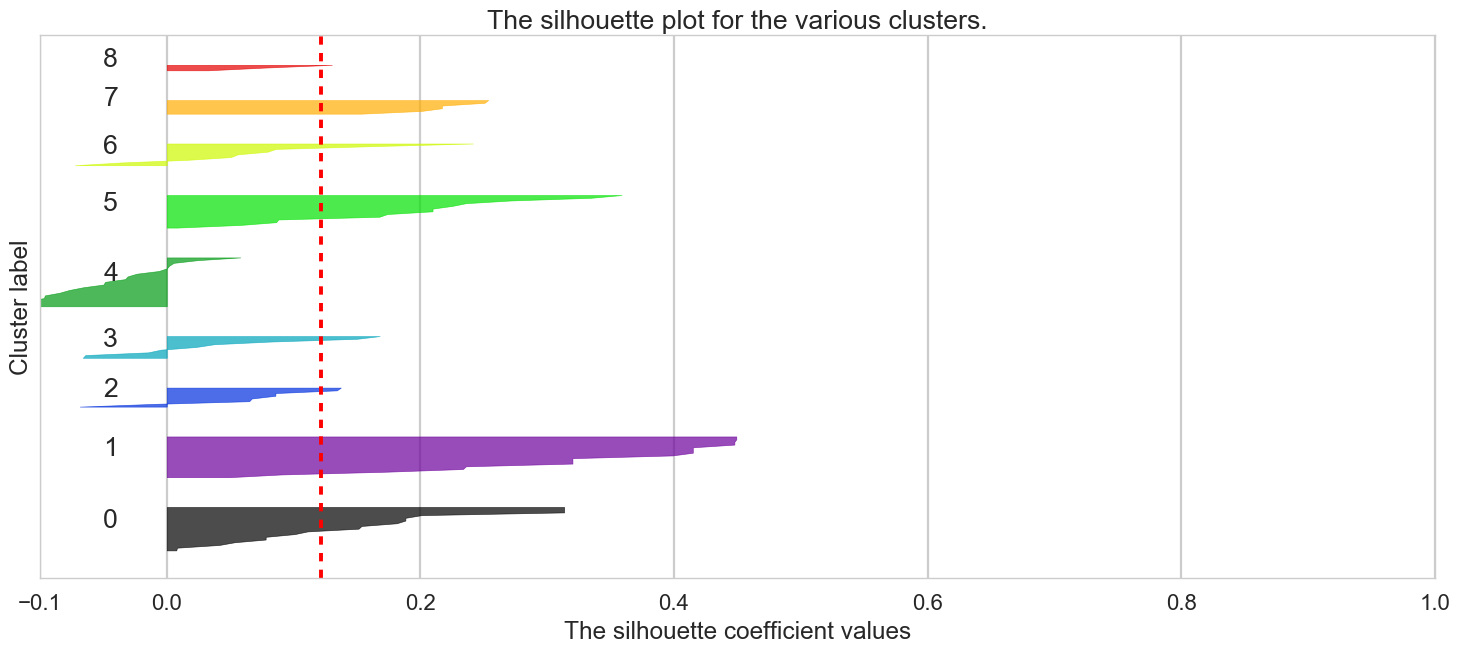

For K = 10, the average silhouette_score is 0.11388045929


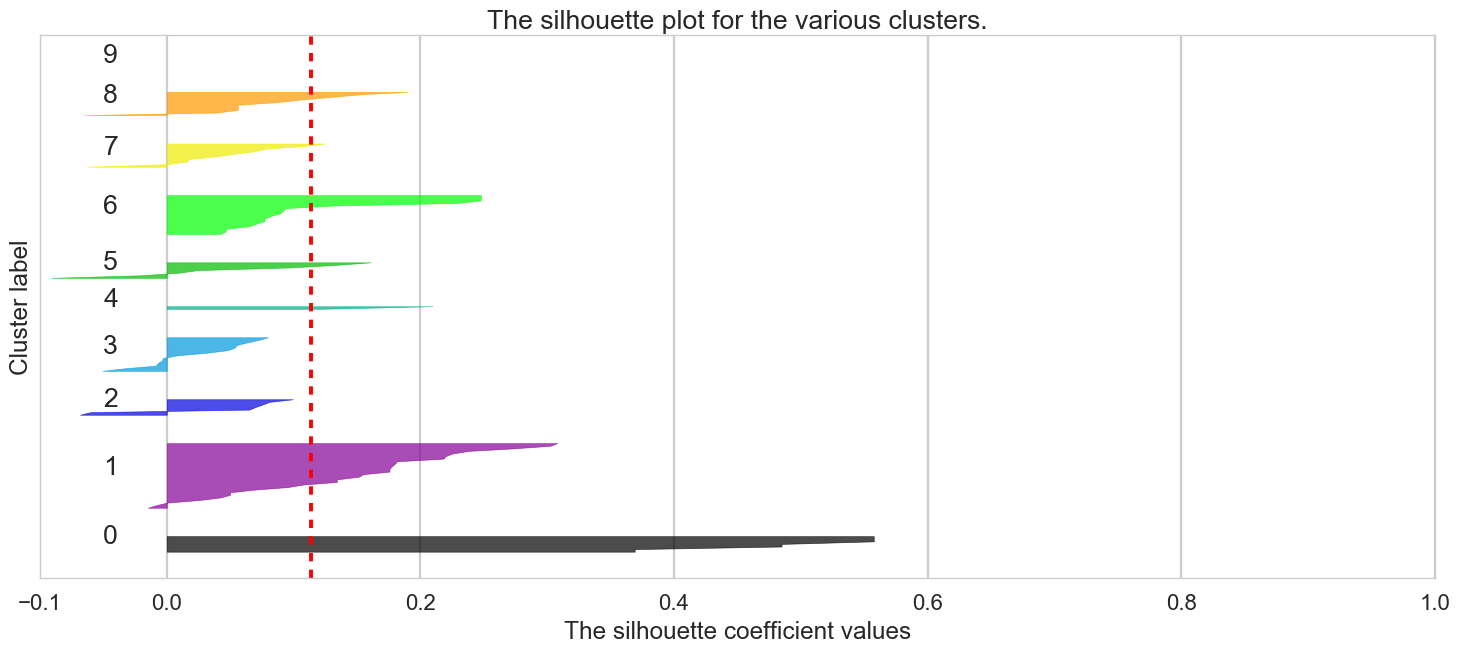

In [16]:
# create plots for average silhouette score for each K
#ninitialize a dictionary for storing the avg silhouette scores
scores = {}
# for each K, create a silhouette plot and store the avg sillhouette score
for K in K_range:
    
    # create a subplot 
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)
    
    # create the silhouette plot, set x axis limits
    ax1.set_xlim([-0.1, 1])
    
    # insert some blank space between the plots for demarcation
    ax1.set_ylim([0, len(x_cols) + (K + 1) * 10])
    
    # do kmeans clustering, set random-state = 5 for reproducibility
    clusterer = KMeans(n_clusters= K, random_state=5)
    cluster_labels = clusterer.fit_predict(x_cols)
    
    # get silhouette scores and print
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    scores[K] = silhouette_avg
    print('For K = {}, the average silhouette_score is {}'.format(K, silhouette_avg))
    
    # compute silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)
    
    y_lower = 10
    for i in range(K):
    # aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
    
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
    
        color = cm.spectral(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.show()     

In [17]:
# put the dictionary info into dataframe for easy plotting
scoresdf = pd.DataFrame.from_dict(scores, orient='index')

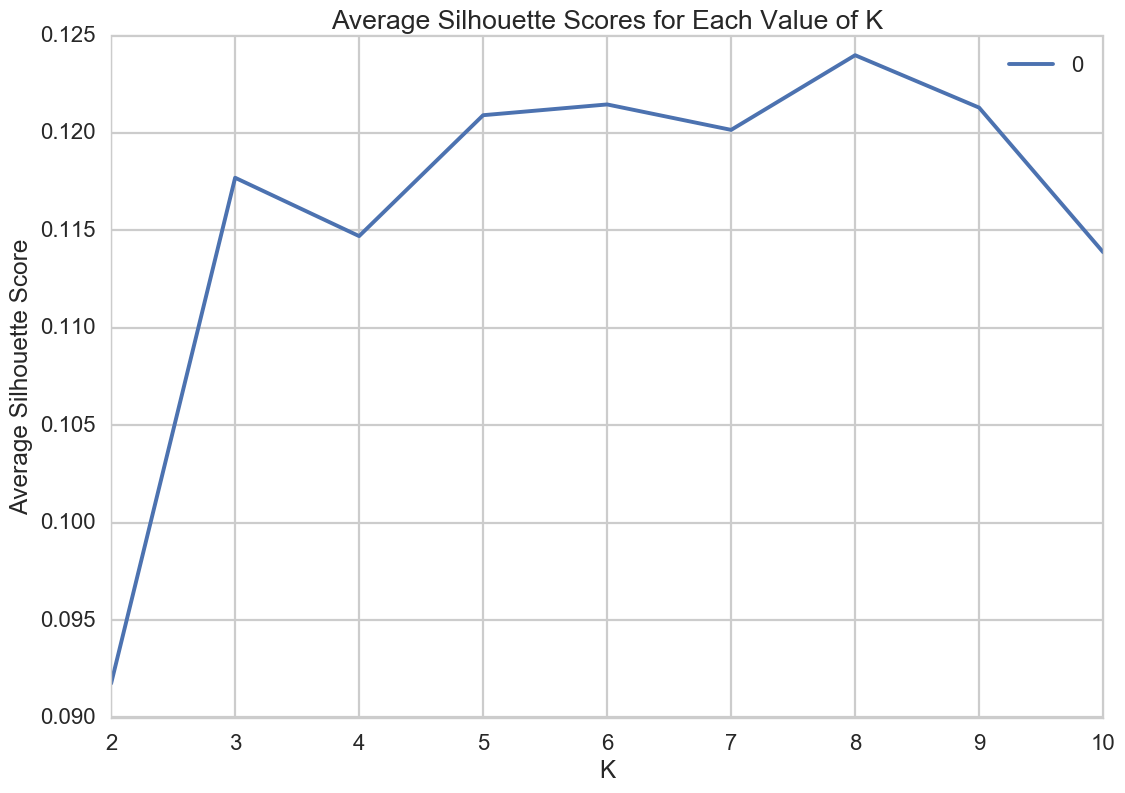

In [18]:
scoresdf.plot(kind='line')
plt.title('Average Silhouette Scores for Each Value of K')
plt.xlabel('K')
plt.ylabel('Average Silhouette Score')

The value of K that gets the best average silhouette score is 8.  This is much more precise than using the elbow method which is just an "eyeball" estimate.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [19]:
#your turn
# Let's try K=8 and K=3, first K=8
K_means = KMeans(n_clusters= 8, random_state= 5).fit_predict(x_cols) 
matrix['cluster'] = K_means

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(x_cols)[:,0]
matrix['y'] = pca.fit_transform(x_cols)[:,1]

matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,cluster,x,y
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5,1.007580,0.108215
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,-0.287539,0.044715
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,-0.392032,1.038391
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.699477,-0.022542
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3,0.088183,-0.471695


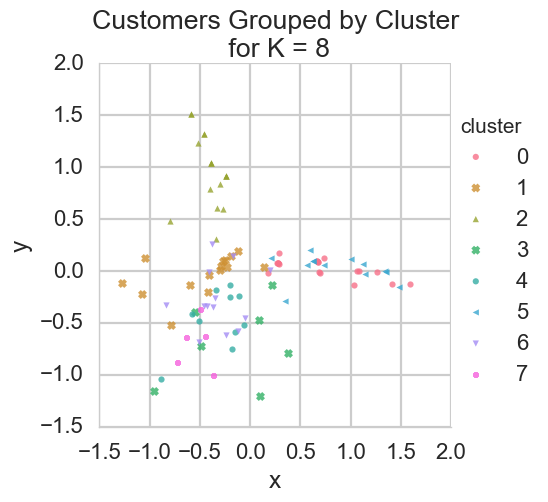

In [21]:
sns.lmplot(x='x', y='y', hue='cluster', data=matrix, fit_reg=False, markers =['o', 'x', '^', 'x', 'o','<', 'v', '+'])
plt.title('Customers Grouped by Cluster\n for K = 8')

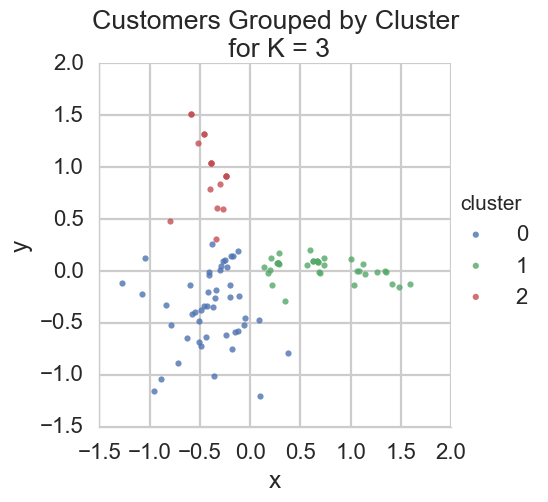

In [22]:
# repeat for K=3
K_means = KMeans(n_clusters= 3, random_state= 5).fit_predict(x_cols) 
matrix['cluster'] = K_means
sns.lmplot(x='x', y='y', hue='cluster', data=matrix, fit_reg=False)
plt.title('Customers Grouped by Cluster\n for K = 3')
plt.savefig('Kmeans.png')

Visually K=3 seems to work the best as there is no overlap in the clusters. There is a lot of overlap between clusters with K=8 so visualizing in 2 dimensions would be a difficult method for choosing the best K.  The silhouette method seems to work the best.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

In [23]:
# merge the transactions file with customer clusters file and then merge with offers file so we can interpret the clusters
customer_clusters = matrix[['customer_name','cluster']]
df = pd.merge(df_transactions, customer_clusters)
df = pd.merge(df_offers, df)

In [24]:
df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster
0,1,January,Malbec,72,56,France,False,Thomas,1,0
1,1,January,Malbec,72,56,France,False,Jackson,1,0
2,1,January,Malbec,72,56,France,False,Mitchell,1,2
3,1,January,Malbec,72,56,France,False,Peterson,1,2
4,1,January,Malbec,72,56,France,False,Wood,1,0


In [25]:
# how many customers per cluster
df.groupby('cluster').customer_name.nunique()

cluster
0    47
1    36
2    17
Name: customer_name, dtype: int64

In [26]:
# group the data by cluster and then varietal
df_sorted = df.groupby(['cluster','varietal'], as_index=False).n.agg(np.sum)

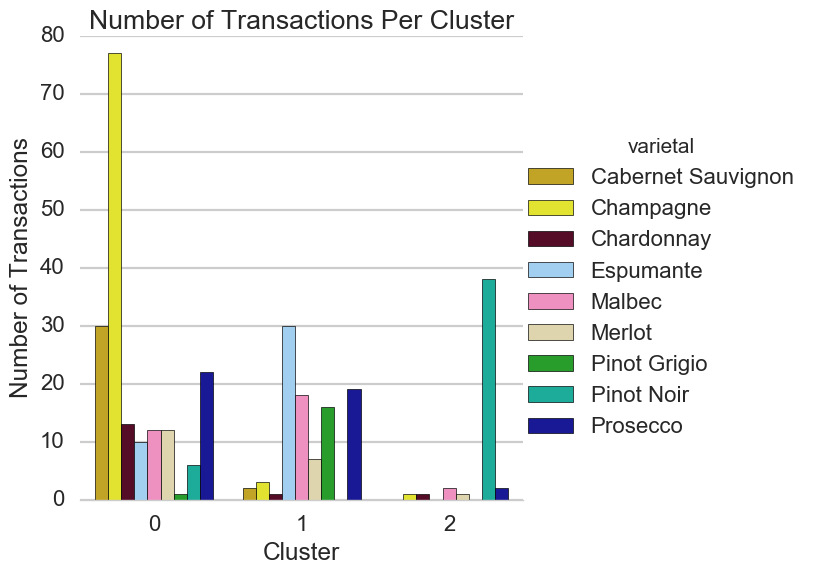

In [27]:
# create a plot of the grouped data

#create a color palette that includes at least 9 unique colors
colors = ["gold", "yellow", "burgundy", "light blue", "pink", "beige", "green", "turquoise", "royal blue" ]
new_palette = sns.xkcd_palette(colors)
sns.set_palette(new_palette)

# make a seaborn factorplot
g = sns.factorplot(x='cluster', y='n', hue='varietal', kind='bar', data=df_sorted, size=6) 
g.despine(left=True)
plt.title('Number of Transactions Per Cluster')
plt.ylabel("Number of Transactions")
plt.xlabel("Cluster")

Cluster "2" has purchased the most amount of Pinot Noirs and clearly prefers Pinot Noirs over any other varietal.  Cluster "0" has purchased the largest amount of Champagnes, Proseccos, and Chardonnays, Merlots, and Cabernets. This group clearly enjoys the largest variety of wines. Cluster "1" has made the most purchases of Espumante, Pinot Grio, and Malbec.  This group possibly enjoys whites a little more than reds.

In [28]:
# group by cluster and discount offered
df_sorted = df.groupby(['cluster','discount'], as_index=False).n.agg(np.sum)

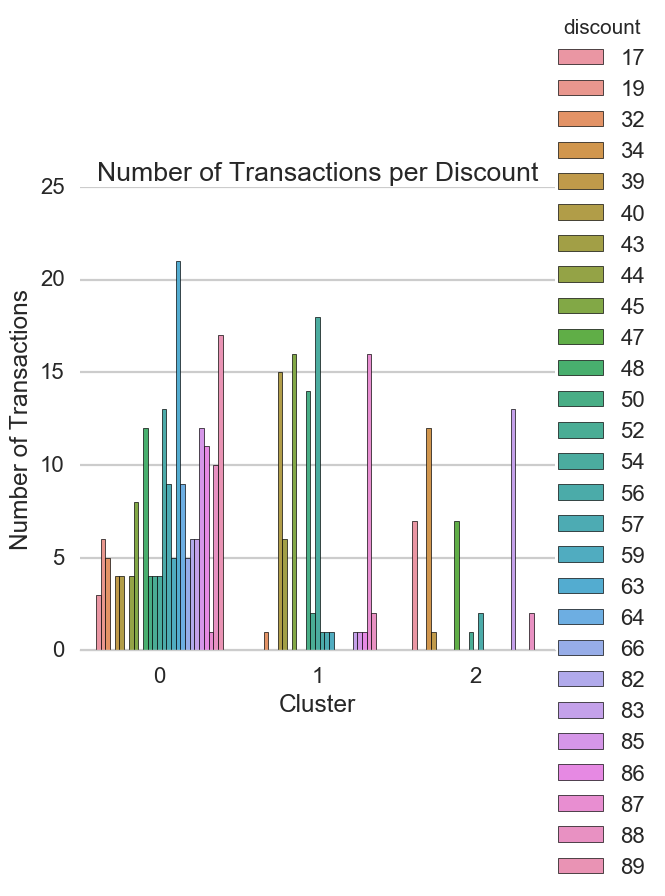

In [29]:
# create a bargraph
g = sns.factorplot(x='cluster', y='n', hue='discount', kind='bar', data=df_sorted, size=6)
g.despine(left=True)

plt.title('Number of Transactions per Discount')
plt.xlabel('Cluster')
plt.ylabel("Number of Transactions")

We can see that Cluster "0" made the most transactions with a discount values in the 60's (blue) and high 80's(salmon) range.  Cluster "2" made most transactions with discount offered in the 80's (purple) and 30's (orange) range. Cluster "1" made the most transactions in the 40's (green) range. Group 2, the Pinot Noir group, is probably going to choose the wine they purchase based on the varietal and will not change buying habits based solely on discount offered.  Group 0, the variety group, is the group that would most likely be influenced by special offers as they enjoy a large variety of wines. Group 1's purchasing will focus mostly on whites, but they can be swayed to purchase reds for the right price.

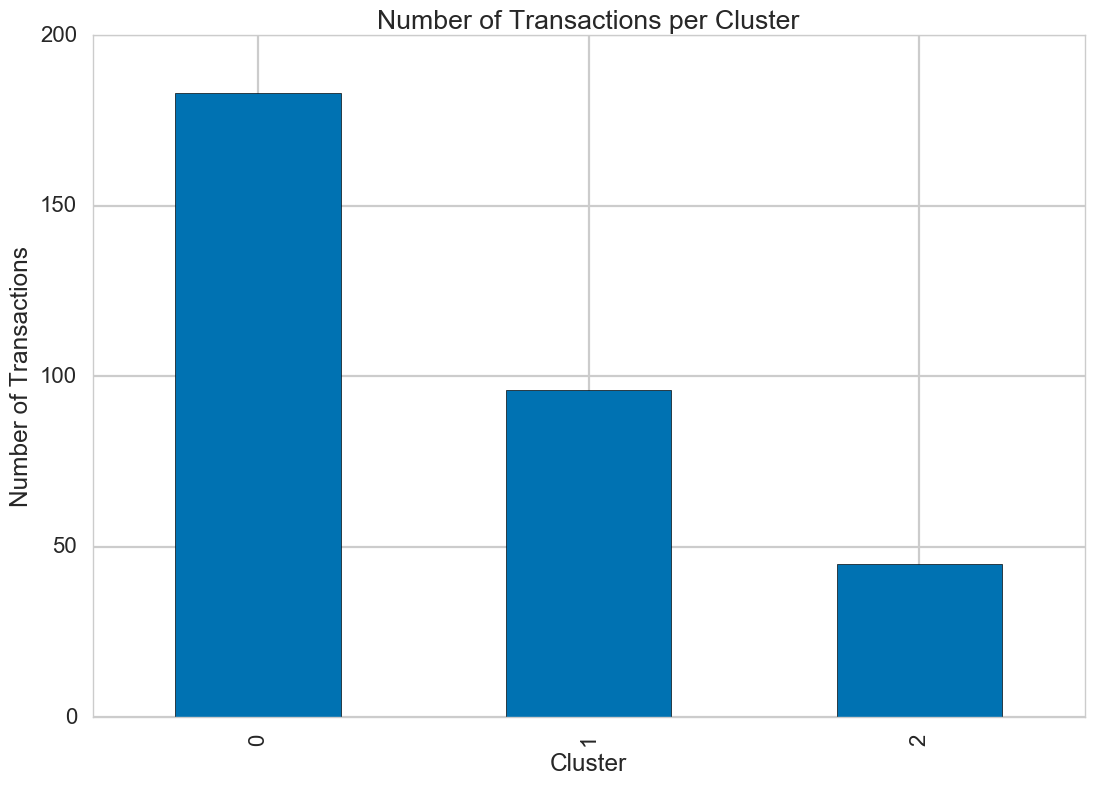

In [30]:
# make a bar graph of number of customers per cluster
sns.set_palette('colorblind')
num_per_cluster = df.cluster.value_counts()
num_per_cluster.plot(kind='bar') 
plt.title('Number of Transactions per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Transactions')

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [31]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [32]:
# create the pandas dataframe for easy plotting
vardf = pd.DataFrame(pca.explained_variance_)

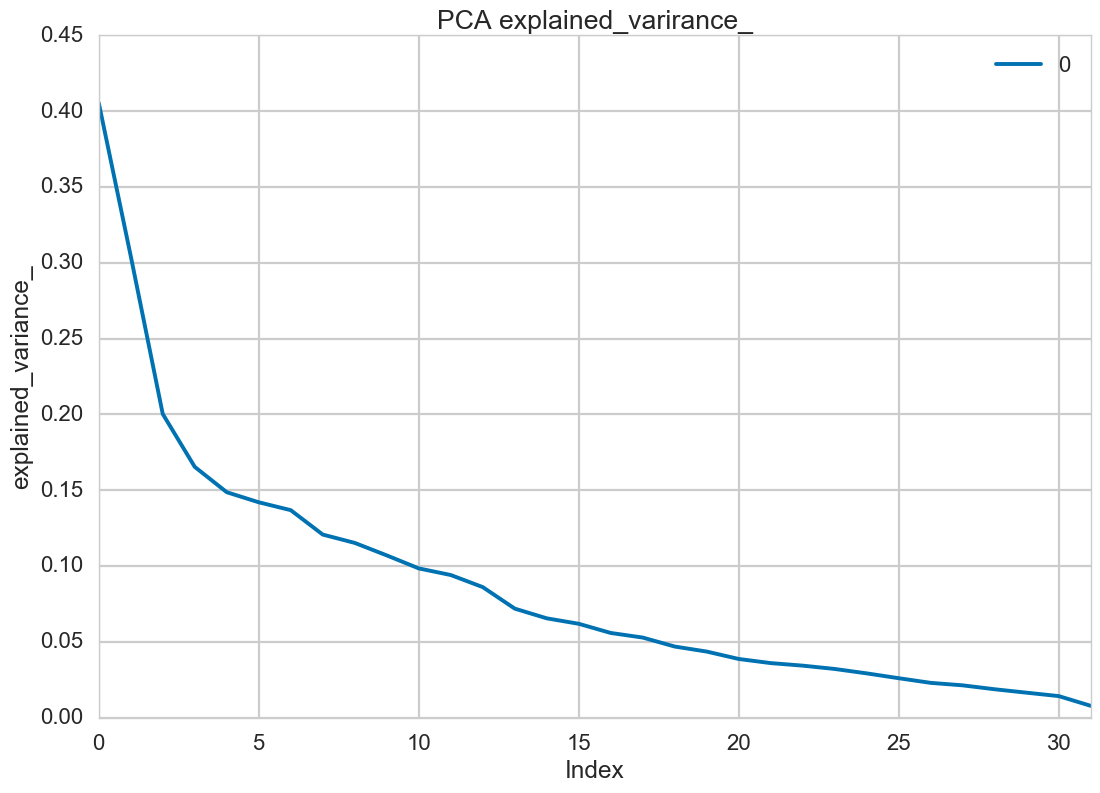

In [33]:
# plot the explained_variance_ field
vardf.plot()
plt.title('PCA explained_varirance_')
plt.xlabel('Index')
plt.ylabel('explained_variance_')

(0, 5)

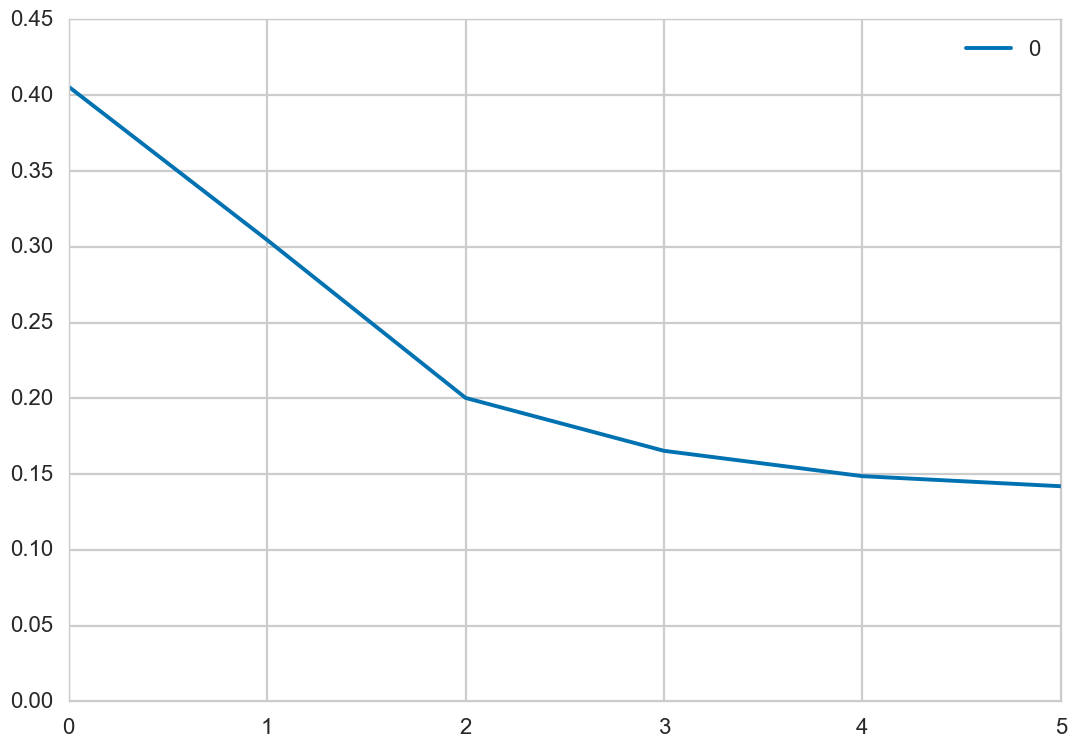

In [34]:
# in order to see more closely where the curve starts to flatten out, plot from x = 0 to x=5
vardf.plot()
plt.xlim(0,5)

Elbow is at x = 2 which corresponds to 3 dimensions.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [35]:
# Your turn

## Links to each Algorithm
* [Affinity Propagation](#Affinity-Propagation)
* [Spectral Clustering](#Spectral-Clustering)
* [Agglomerative Clustering](#Agglomerative-Clustering)
* [DBSCAN](#DBSCAN)


## Affinity propagation

In [36]:
from sklearn.cluster import AffinityPropagation

In [37]:
# parameters are damping and sample preference.  Using default damping = 0.5 and preference=None
af = AffinityPropagation(damping = 0.5).fit(x_cols)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
matrix['cluster'] = labels
n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: {}'.format(n_clusters_))

Estimated number of clusters: 14


Let's compare the silhouette coefficient to the ones computed for the Kmeans clustering done above.  Best score for Kmeans was for K = 5.

In [38]:
print('Best silhouette score for Kmeans was: {}'.format(scores[8]))

Best silhouette score for Kmeans was: 0.123987821069


In [39]:
from sklearn import metrics
silhouette_score = metrics.silhouette_score(x_cols, labels, metric='sqeuclidean')
print('Silhouette Coefficient: {}'.format(silhouette_score))

Silhouette Coefficient: 0.179783376642


In [40]:
#Let's save all the silhouette scores in a dictionary
silhouette_scores ={}
silhouette_scores['Kmeans'] = scores[8]
silhouette_scores['Affinity Propagation'] = silhouette_score

Let's plot the clusters to get a visual feel for them.

In [41]:
# let's define a matrix with just the columns we need for plotting
afmatrix = matrix[['cluster','x','y']]

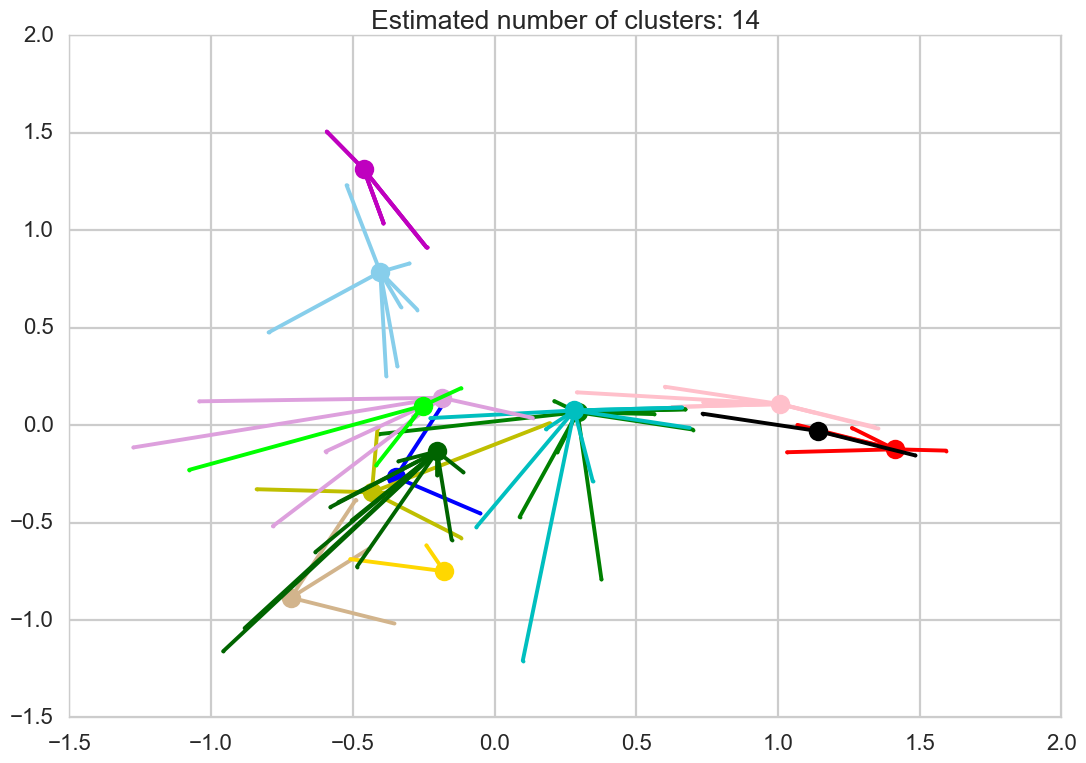

In [42]:
import matplotlib.pyplot as plt
from itertools import cycle
import matplotlib.colors as mcolors


plt.close('all')
plt.figure(1)
plt.clf()

list_of_colors = ['pink', 'b', 'r','g','y','k','m','c', 'tan', 'gold', 'plum', 'lime', 'darkgreen', 'skyblue']
for k, col in zip(range(n_clusters_), list_of_colors):
    # define the cluster group for the k value
    cluster_group = afmatrix[afmatrix.cluster == k].reset_index()
    # get the x,y coordinate of the cluster center
    cluster_center = afmatrix.ix[cluster_centers_indices[k],1:3]
    #plot a data point for each point in the cluster in the specified color and marker
    plt.scatter(cluster_group['x'], cluster_group['y'], color=col, marker='.')
    # plot the cluster center making it larger than the data points
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    # plot a line from the cluster center to the cluster group data point for each point
    for i in range(len(cluster_group)):
        plt.plot([cluster_center[0], cluster_group.loc[i,'x']], [cluster_center[1], cluster_group.loc[i,'y']], col)
        
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

We can see that many of the clusters overlap. 

## Spectral Clustering

In [43]:
from sklearn.cluster import SpectralClustering
# set n_clusters = 3 to do an "apples to apples" comparison with Kmeans we did above
spectral = SpectralClustering(n_clusters=3, random_state = 5).fit(x_cols)

labels = spectral.labels_
matrix['cluster'] = labels
silhouette_score = metrics.silhouette_score(x_cols, labels, metric='sqeuclidean')
print('Silhouette Coefficient: {}'.format(silhouette_score))

Silhouette Coefficient: 0.132785673785


In [44]:
silhouette_scores['Spectral Clustering'] = silhouette_score

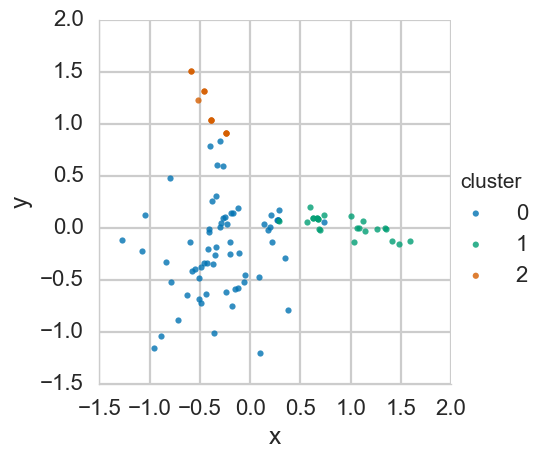

In [45]:
# plot the clusters in 2 dimensions to get a visual feel
sns.lmplot(x='x', y='y', hue='cluster', data=matrix, fit_reg=False)
plt.savefig('spectral.png')

This result is very similar to the K-means clustering result for K=3. This is not surprising since Spectral Clustering "does a low-dimension embedding of the affinity matrix between samples, followed by a KMeans in the low dimensional space."  This works well for a small number of clusters. 

## Agglomerative Clustering

In [46]:
from sklearn.cluster import AgglomerativeClustering
# parameteres are number of clusters, linkage type, distance
# default linkage is "ward" and default "distance" is "euclidean"
# use default settings and set n_clusters to 3
agc = AgglomerativeClustering(n_clusters = 3, linkage='ward').fit(x_cols)
labels= agc.labels_
matrix['cluster'] = labels
silhouette_score = metrics.silhouette_score(x_cols, labels, metric='sqeuclidean')
print('Silhouette Coefficient: {}'.format(silhouette_score))

Silhouette Coefficient: 0.173450516093


In [47]:
silhouette_scores['Agglomerative Clustering'] = silhouette_score

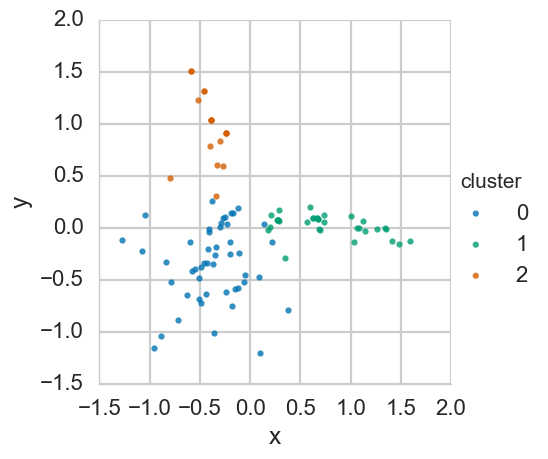

In [48]:
sns.lmplot(x='x', y='y', hue='cluster', data=matrix, fit_reg=False) #, markers = ['o','^', 'v'])
plt.savefig('agglomerate.png')

With n_clusters set at 3, the result is very similar to K-means.

## DBSCAN

In [49]:
from sklearn.cluster import DBSCAN
# parameter is neighborhood size, eps is maximum distance between two points for them to be considered in the same cluster
# the default metric for measuring distance is "euclidean".
dbscan = DBSCAN(min_samples=3, eps=1.4).fit(x_cols)
labels = dbscan.labels_
matrix['cluster'] = labels
silhouette_score = metrics.silhouette_score(x_cols, labels, metric='sqeuclidean')
print('Silhouette Coefficient: {}'.format(silhouette_score))

Silhouette Coefficient: 0.0292151479531


In [50]:
silhouette_scores['DBSCAN'] = silhouette_score

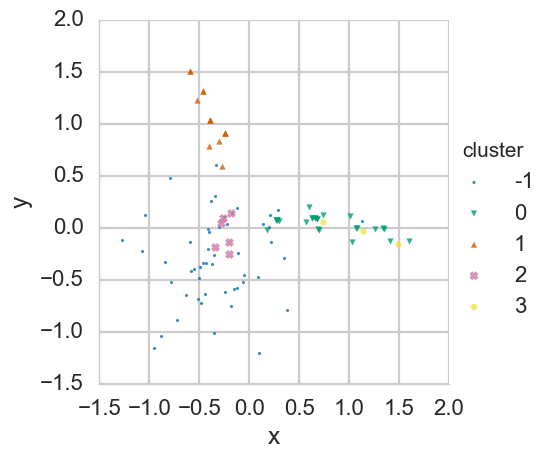

In [51]:
sns.lmplot(x='x', y='y', hue='cluster', data=matrix, fit_reg=False, markers=[".", "v", "^","x","o"] )

DBSCAN is "Good for data which contains clusters of similar density".  It does not seem to give very good results with this dataset.  The points labeled -1 are considered "noise".

In [52]:
for key, value in silhouette_scores.items():
    print('{}:\n {}\n'.format(key,value))

Spectral Clustering:
 0.132785673785

Affinity Propagation:
 0.179783376642

Agglomerative Clustering:
 0.173450516093

Kmeans:
 0.123987821069

DBSCAN:
 0.0292151479531



Doing an "apples to apples" comparison with K=3 clusters, Agglomerative Clustering delivers the highest silhouette score.  Affinity Propagation gave the highest score and it does not require one to specify the number of clusters ahead of time which is an advantage.

Let's use Agglomerative Clustering with K=8 and see if we get a higher silhouette score.

In [54]:
agc = AgglomerativeClustering(n_clusters = 8, linkage='ward').fit(x_cols)
labels= agc.labels_
matrix['cluster'] = labels
silhouette_score = metrics.silhouette_score(x_cols, labels, metric='sqeuclidean')
print('Silhouette Coefficient: {}'.format(silhouette_score))

Silhouette Coefficient: 0.250567988647


This is the best score we have seen thus far.  However, all the scores indicate "no substantial structure is found".